# Wine taste prediction

---

# Contents

* [Introduction](#Introduction)
* [Read the Data (**A**)](#A-—-Read-the-Data)
* [Exploratory Data Analysis (**B**)](#B-—-Exploratory-Data-Analysis)
* [Stepwise Selection by Cross-Validation (**C**)](#C-—-Stepwise-Selection-by-Cross-Validation)
* [$L_2$ and $L_1$ Regularisation (**D**)](#D-—-$L_2$-and-$L_1$-Regularisation)
* [Discussion (**E**)](#E-—-Discussion)
* [Conclusion](#Conclusion)
* [References](#References)

---

# Introduction

The files "Wine_training.csv" (training set) and "Wine_testing.csv" (test set) consist of data relating to wine, in particular, values for a binary response (*quality*: "good" or "bad") as well as for eleven potential predictors: *fixed acidity*, *volatile acidity*, *citric acid*, *residual sugar*, *chlorides*, *free sulfur dioxide*, *total sulfur dioxide*, *density*, *ph*, *sulphates*, and *alcohol*.  Different model selection methods are used — in particular, forward stepwise selection by cross-validation, $L_2$ regularisation, and $L_1$ regularisation — to determine the best logistic regression model for the given data, being the most predictive model as measured by area under the receiving operator characteristic (ROC) curve (AUC), in relation to predictions for the test set.

---

# A — Read the Data

Read the training and testing sets (in "Wine_training.csv" and "Wine_testing.csv").  Abbreviate the variable (column) names.

In [1]:
# Read the training set (in "Wine_training.csv").
d <- read.csv("Wine_training.csv")

# Read the testing set (in "Wine_testing.csv").
d_test <- read.csv("Wine_testing.csv")

In [2]:
# Define the original variable (column) names.
names_ <- names(d)

# Abbreviate each variable (column) name to its first two letters (training).
colnames(d) <- tolower(substr(colnames(d), 1, 2))

# Abbreviate each variable (column) name to its first two letters (test).
colnames(d_test) <- tolower(substr(colnames(d_test), 1, 2))

# Return the original and abbreviated variable (column) names.
names_ <- data.frame(cbind(names_, colnames(d)))
colnames(names_) <- NULL
names_

1,fixed.acidity,fi
2,volatile.acidity,vo
3,citric.acid,ci
4,residual.sugar,re
5,chlorides,ch
6,free.sulfur.dioxide,fr
7,total.sulfur.dioxide,to
8,density,de
9,pH,ph
10,sulphates,su
11,alcohol,al


---

# B — Exploratory Data Analysis

There are eleven potential predictors, all continuous, and a single, binary, response: *quality* (*qu*).  Out of 3,283 observations, 2,178 observations (approximately 66%) are classified as "good", and 1,105 observations (approximately 34%) are classified as "bad".

Summary statistics, and histograms and box plots for each of the (potential) predictors (by response), are shown below.  The main observations are:
* the distribution of values for "good" and "bad" observations is only noticeably different for *alcohol* (*al*);
* for most predictors, there are at least some outliers by conventional definition (as shown on the box plots);
* the distribution of values (for both "good" and "bad" observations) appears to be:
    * approximately normal for *fixed acidity* (*fi*), *total sulfur dioxide* (*to*), *density* (*de*), *ph* (*ph*), and *sulphates* (*su*);
    * skewed for *volatile acidity* (*vo*), *citric acid* (*ci*), *residual sugar* (*re*), *chlorides* (*ch*) [strongly skewed, with a large number of outliers], *free sulfur dioxide* (*fr*), and *alcohol* (*al*) [the distribution of values for "good" observations is skewed, the distribution of values for "bad" observations is more symmetrical];
* each of *residual sugar* (*re*) and *density* (*de*) appear to contain an extreme outlier value;
* there appears to be a reasonably strong (linear) correlation between some of the predictors, for example, between *density* (*de*) and *residual sugar* (*re*), between *alcohol* (*al*) and *density* (*de*), between *total sulfur dioxide* (*to*) and *free sulfur dioxide* (*fr*), and between *density* (*de*) and *total sulfur dioxide* (*to*); and
* the range and magnitude of values for each of the predictors will be relevant for the interpretation of the coefficients for any logistic regression model.

It is unecessary (and, although not shown here, demonstrably ineffectual) to transform the values for any of the predictors.  That is, the logistic regression model does not assume, for example, that the distribution of values for any of the predictors is normal (James et al, 2015, pp 151; Hastie et al, 2009, pp 127-128).  Neither does it appear to make any practical difference to remove observations with even the most extreme outlier values.

In [3]:
# Return the head of the data.
head(d)

,fi,vo,ci,re,ch,fr,to,de,ph,su,al,qu
1,7,0.27,0.36,20.7,0.045,45,170,1.001,3,0.45,8.8,good
2,6.3,0.3,0.34,1.6,0.049,14,132,0.994,3.3,0.49,9.5,good
3,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.4,9.9,good
4,8.1,0.28,0.4,6.9,0.05,30,97,0.9951,3.26,0.44,10.1,good
5,6.2,0.32,0.16,7,0.045,30,136,0.9949,3.18,0.47,9.6,good
6,8.1,0.27,0.41,1.45,0.033,11,63,0.9908,2.99,0.56,12,bad


In [4]:
# Return summary statistics for each of the variables.
summary(d)

       fi               vo               ci               re        
 Min.   : 3.800   Min.   :0.0800   Min.   :0.0000   Min.   : 0.600  
 1st Qu.: 6.300   1st Qu.:0.2100   1st Qu.:0.2700   1st Qu.: 1.700  
 Median : 6.800   Median :0.2600   Median :0.3200   Median : 4.800  
 Mean   : 6.852   Mean   :0.2803   Mean   :0.3357   Mean   : 6.031  
 3rd Qu.: 7.300   3rd Qu.:0.3275   3rd Qu.:0.3900   3rd Qu.: 9.000  
 Max.   :14.200   Max.   :1.1000   Max.   :1.6600   Max.   :65.800  
       ch                fr               to              de        
 Min.   :0.00900   Min.   :  2.00   Min.   :  9.0   Min.   :0.9871  
 1st Qu.:0.03600   1st Qu.: 23.00   1st Qu.:107.0   1st Qu.:0.9917  
 Median :0.04300   Median : 33.00   Median :133.0   Median :0.9936  
 Mean   :0.04604   Mean   : 35.05   Mean   :137.7   Mean   :0.9938  
 3rd Qu.:0.05000   3rd Qu.: 45.00   3rd Qu.:166.0   3rd Qu.:0.9958  
 Max.   :0.34600   Max.   :289.00   Max.   :440.0   Max.   :1.0390  
       ph              su         

In [5]:
# Return the correlations between each of the predictors,
# in descending order of magnitude.
cor_ <- as.data.frame.table(cor(d[ , -ncol(d)]))
colnames(cor_) <- c("a", "b", "cor")
cor_ <- cor_[cor_$a != cor_$b, ]
cor_ <- cor_[order(abs(cor_$cor), decreasing = TRUE), ]
cor_ <- cor_[seq(1, nrow(cor_), 2), ]
cor_$cor <- round(cor_$cor, 2)
rownames(cor_) <- 1:nrow(cor_)
print(cor_[1:10, ])

    a  b   cor
1  de re  0.82
2  al de -0.76
3  to fr  0.63
4  de to  0.53
5  al to -0.45
6  ph fi -0.43
7  al re -0.40
8  to re  0.40
9  al ch -0.36
10 ci fi  0.30


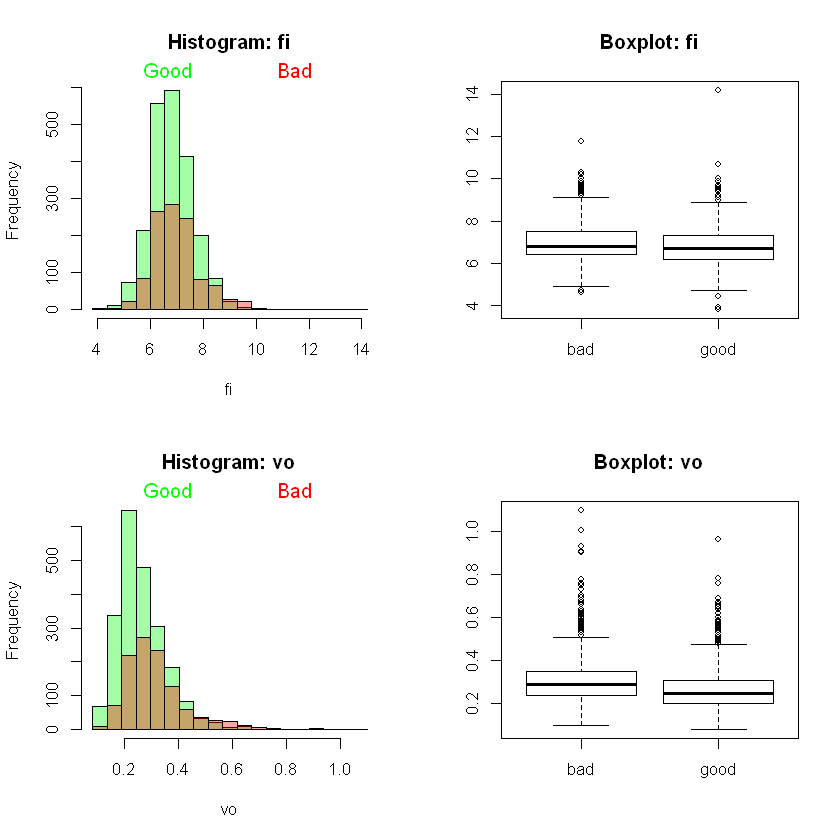

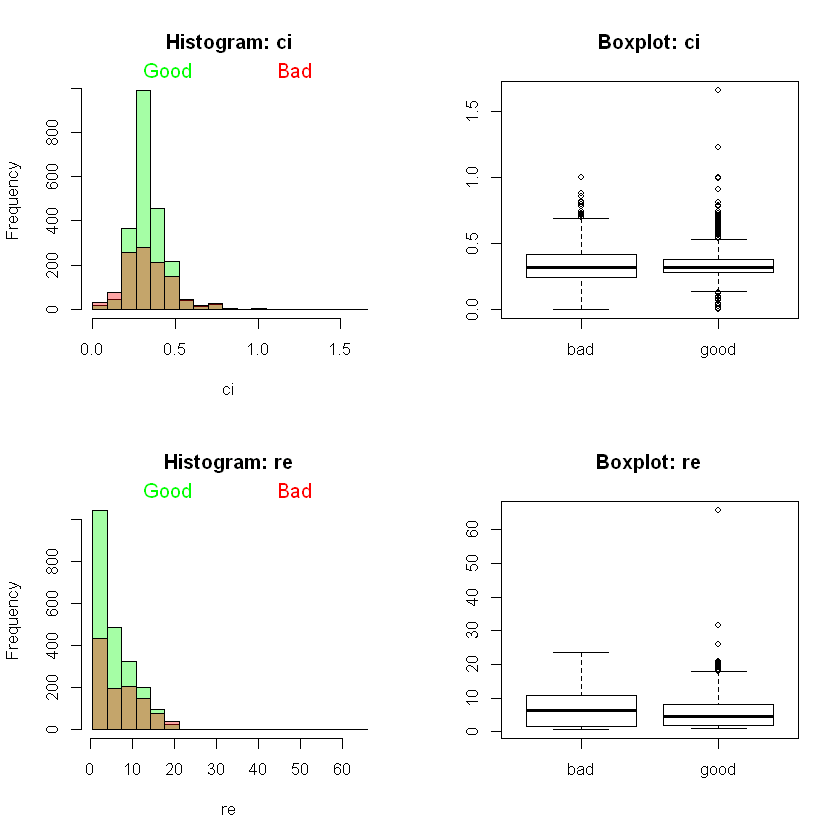

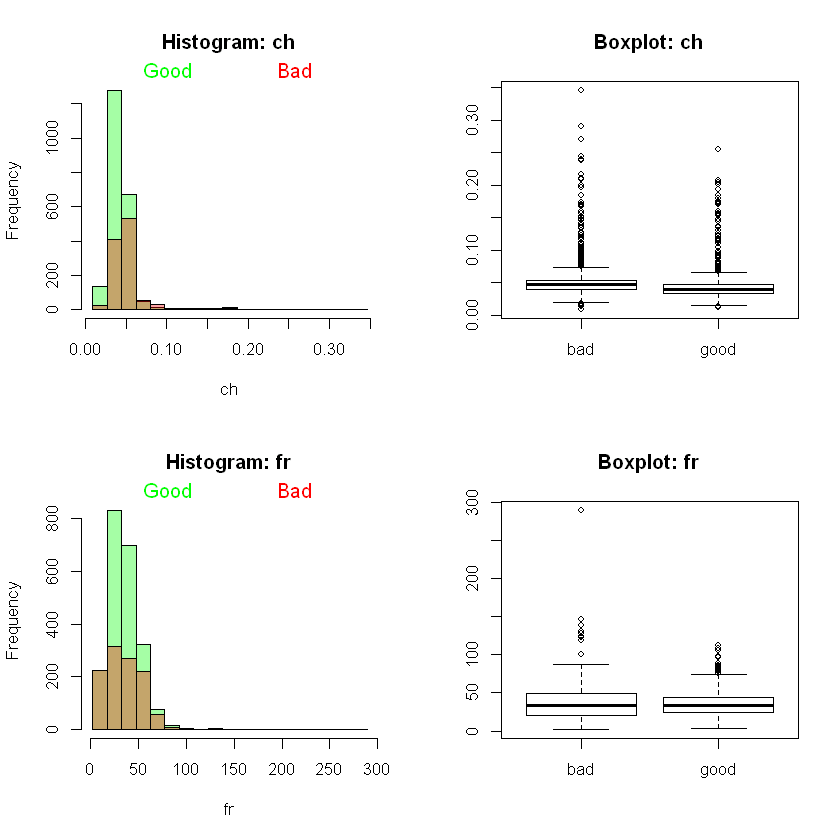

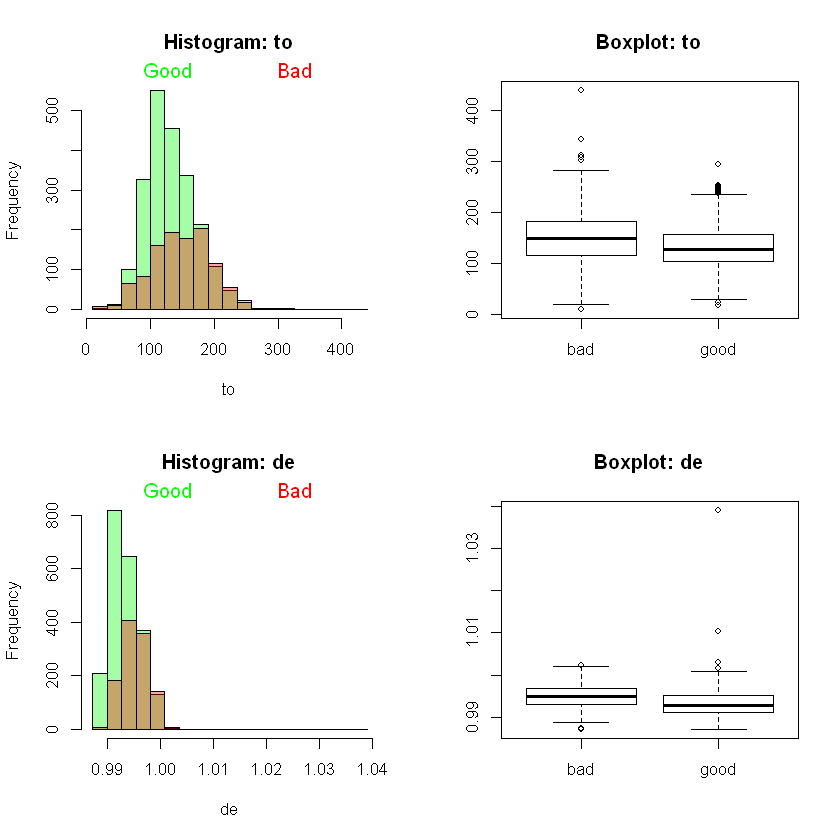

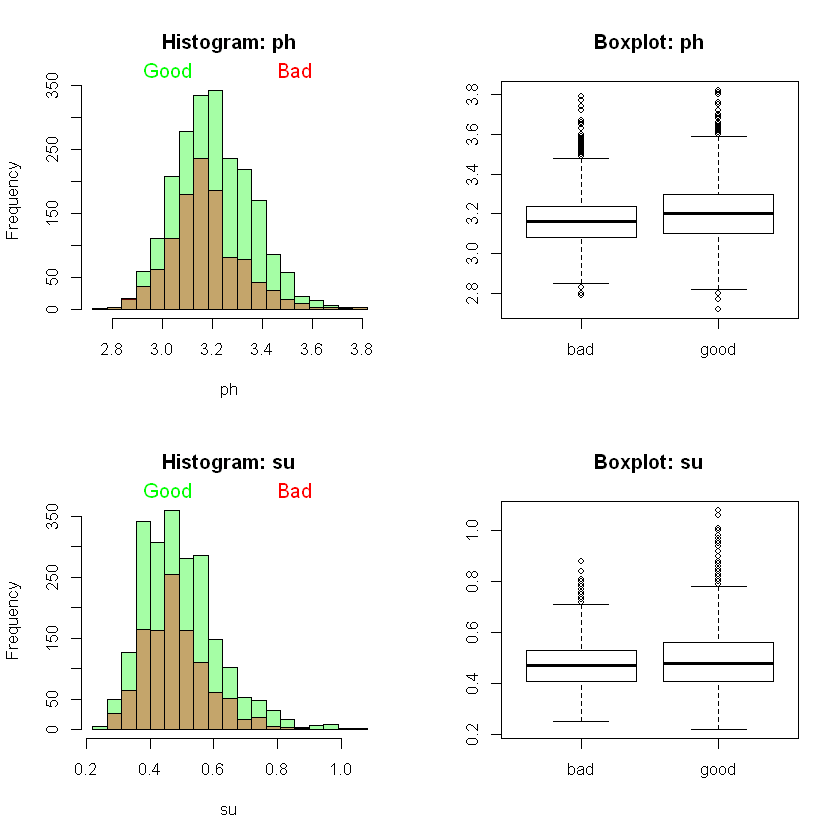

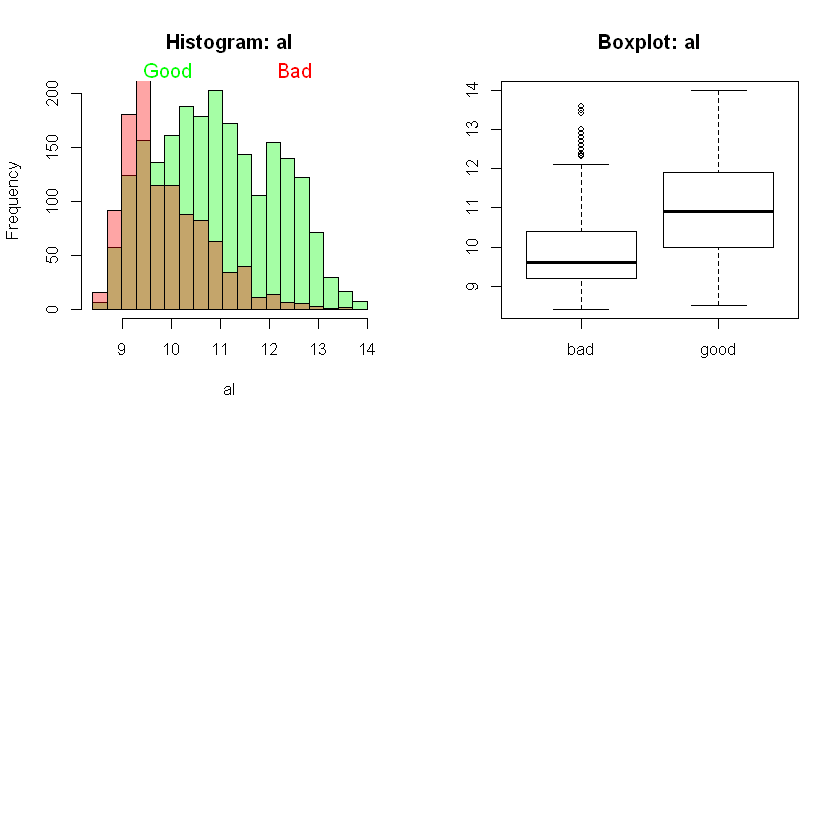

In [6]:
# Define a two-row by two-column plotting area.
par(mfrow = c(2, 2))

# Plot a histogram and box plot for each of the predictors,
# by response ("good" or "bad").
for (x in colnames(d[-ncol(d)])) {
    min_d <- min(d[ , x])
    max_d <- max(d[ , x])
    b <- seq(min_d, max_d, length.out = 20)
    hist(d[ , x][d$qu == "good"], col = rgb(0, 1, 0, 0.35), breaks = b,
         main = paste("Histogram: ", x, sep = ""), xlab = x)
    hist(d[ , x][d$qu == "bad"], col = rgb(1, 0, 0, 0.35), breaks = b,
         add = TRUE)
    mtext(c("Good", "Bad"), adj = c(0.25, 0.75), col = c("green", "red"))
    boxplot(d[ , x] ~ d$qu, main = paste("Boxplot: ", x, sep = ""))
}

---

# C — Stepwise Selection by Cross-Validation

## C.1 — Load Package *pROC*

Load the package *pROC*, which provides for:
* computing and plotting ROC curves;
* calculating AUC; and
* estimating the variance (and standard error) of AUC.

In [7]:
# Load the package *pROC*.
library(pROC)

Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var



## C.2 — Define Functions

### C.2.1 — Function: Create *k* Cross-Validation Folds

Define a function to create *k* cross-validation folds.

Note that this method produces cross-validation folds of the same size (or as close to the same size as possible), by randomly "shuffling" *n* + 1 repetitions of the values 1 to *k* (where *n* is the number of observations per cross-validatoin fold).  This is in contrast to the method used by James et al (2015, p 250), which produces randomly-sized cross-validation folds.

In [8]:
# Create *k* cross-validation folds for the data *d*.
# Parameters:
#   d:  data (data frame)
#   k:  number of folds (default 10)
# Returns:
#   id: vector of values, from 1 to k,
#       indicating the relevant fold for each row of *d*
fold <- function(d, k = 10) {
    
    # The number of rows in *d*.
    r <- nrow(d)
    
    # The number of rows per fold.
    n <- r %/% k
    
    # Minimally "over-sample" from the values 1 to *k*,
    # by "shuffling" *n* + 1 repetitions of the values 1 to *k*,
    # and "take" *r* values (to account for an uneven division of *r*).
    id <- sample(rep(1:k, n + 1))[1:r]
    
    return(id)
}

### C.2.2 — Function: Cross-Validation

Define a function to cross-validate AUC for specified predictors (for a logistic regression model) in relation to given data.

Although not shown here, for the purpose of implementing the so-called one-standard-error rule (James et al, 2015, p 214), various methods can be used for determining cross-validated AUC and, in particular, the standard error for cross-validated AUC.  Cross-validated AUC can be calculated as the mean of the AUC for each of the *k* cross-validation folds.  The standard error can be estimated based on these *k* values (including via bootstrapping).  This appears to be the method used by, for example, the `cv.glmnet` function in the package *glmnet* (see Friedman et al, 2016, p 5).  However, given random variation between different cross-validation folds, for a value of *k* of ten (that is, ten-fold cross-validation, producing ten AUC values, one for each of the ten cross-validation folds), the estimated standard error is "unstable" (that is, there is a large amount of variation in the estimated standard error for different cross-validation "splits").

As such, a different approach has been used.  Instead of averaging the AUC values for each of the *k* cross-validation folds, the predictions (and "true" class values) for each of the *k* cross-validation folds are accumulated (the predictions for each of the folds is independent to the extent that the test sets are disjoint, although the training sets overlap, but this is the same whether AUC values are averaged or accumulated), and a single ROC curve (and corresponding AUC) is calculated for the predictions for all *k* cross-validation folds (as to generating ROC curves by ranking a set of predictions: Fawcett, 2005, pp 863, 866).  (Although not shown here, as you would expect, unless a given model is "unstable", the single AUC value for the predictions for all *k* cross-validation folds, and the average of each of *k* AUC values for the predictions of each of *k* cross-validation folds, are extremely similar.)  The standard error for the single AUC value is calculated using the so-called DeLong method, as implemented in the `var.roc` function of the package *pROC* (see Robin et al, 2016, pp 6, 78-82).  The standard error for cross-validated AUC calculated in this way is consistent with the standard error calculated on the basis of AUC values for each of *k* cross-validated folds but, crucially, is much more stable (there is considerably less variation in the estimated standard error for different cross-validation "splits").

In [9]:
# Cross-validate AUC for the predictors specified in *f*,
# for a logistic regression model, for the data *d*.
# Parameters:
#   d: data (data frame)
#   f: formula specifying the predictors
#   k: number of folds (default 10)
#   s: random seed (default 1)
# Returns:
#   list:
#     - AUC
#     - AUC standard error
#     - ROC curve (roc object)
xv <- function(d, f, k = 10, s = 1) {
    
    # Set the random seed.
    set.seed(s)
    
    # Create *k* cross-validation folds for the data *d*.
    id <- fold(d, k)
    
    # Initialise the set of all prediction probabilities,
    # for all *k* cross-validation folds.
    p_ <- NULL
    
    # Initialise the set of all "true" class values,
    # for all *k* cross-validation folds.
    t_ <- NULL
    
    # For each of *k* folds:
    for (i in 1:k) {
        
        # Define the training set.
        tr <- d[i != id, ]
        
        # Define the test set.
        te <- d[i == id, ]
        
        # Fit a logistic regression model for the specified predictors.
        m <- glm(f, tr, family = binomial)
        
        # Apply the model to the test set.
        p <- predict(m, te, "response")
        
        # Accumulate the prediction probabilities.
        p_ <- c(p_, p)
        
        # Accumulate the "true" class values.
        t_ <- c(t_, as.vector(te$qu))
    }

    # Compute the ROC curve for the set of all prediction probabilities.
    r <- roc(t_, p_)
    
    # Compute AUC.
    a <- pROC::auc(r)
    
    # Compute AUC standard error.
    se <- sqrt(var(r))
    
    return(list("AUC" = a, "SE" = se, "ROC" = r))
}

### C.2.3 — Function: Stepwise Variable Selection by Cross-Validation

Define a function to perform forward stepwise variable selection using cross-validated AUC.

This function uses cross-validated AUC for variable selection at each step, in accordance with the following procedure:
<i>
* Until all predictors are included in the current model:
    * For each predictor not yet included in the current model:
        * Calculate cross-validated AUC for the current model plus the given predictor.
    * Add the predictor corresponding to the largest increase in AUC (versus the current model) to the current model.
</i>

This method provides for both variable selection and best-single-model selection: the step corresponding to the highest AUC score represents the best subset of predictors (within the limitations of a stepwise procedure) and, equivalently, the single best model (as cross-validated AUC is used as the stepwise metric, all possible models for each step are tested within the stepwise procedure itself).  Note that this is similar to the method suggested by Charpentier (2015).

This is in contrast to the method suggested by James et al (2015, p 250), which involves best-subset selection within each of *k* cross-validation folds, calculating prediction error for each subset, for each cross-validation fold, and taking the average error for models of each size (over the *k* cross-validation folds).  This method produces models with different subsets of predictors for each fold.  As such, although it might indicate the best average number of predictors, it does not identify a particuar subset of predictors.

In [10]:
# Perform forward stepwise selection using cross-validated AUC,
# for a logistic regression model, for the data *d*.
# Parameters:
#   d: data (data frame)
# Returns:
#   best (data frame):
#     - step number
#     - predictor name
#     - AUC
#     - AUC standard error
step_xv <- function(d) {
    
    # The set of predictors.
    x <- colnames(d[1:(ncol(d) - 1)])
    
    # The response.
    y <- colnames(d[ncol(d)])

    # The number of predictors.
    n <- length(x)
    
    # Initialise the return value (data frame).
    best <- data.frame("Step" = 1:n, "Var" = "", "AUC" = 0, "SE" = 0,
                       stringsAsFactors = FALSE)

    # For each of *n* predictors:
    for (i in 1:n) {
        
        # Start a new plot.
        plot.new()
        plot.window(xlim = c(1, 0), ylim = c(0, 1))
        grid()
        box()
        abline(1, -1, col = "blue", lty = 2)
        l <- seq(0,1,0.2)
        axis(1, at = rev(l), labels = format(l, 2))
        axis(2)
        title(main = "ROC Curves", xlab = "FPR", ylab = "TPR")
        
        # The number of predictors not yet in the model.
        m <- length(x)

        # For each of *m* predictors not yet in the model:
        for (j in 1:m) {
            
            # Define the formula for the current model plus the predictor.
            f <- paste(y, paste(c(best$Var[1:i], x[j]), collapse = " + "),
                       sep = " ~ ")
            f <- formula(f)
            
            # Cross-validate AUC for the candidate model.
            xv_j <- xv(d, f)
            
            # Plot the ROC curve.
            plot(xv_j$ROC, col = "grey", lwd = 1, add = TRUE)
            
            # If the AUC is larger than the current largest AUC,
            # update the best candidate model.
            if (xv_j$AUC > best$AUC[i]) {
                best$AUC[i] <- xv_j$AUC
                best$SE[i] <- xv_j$SE
                best_r <- xv_j$ROC
                best_j <- j
            }
        }
        
        # Add the best predictor to the current model.
        best$Var[i] <- x[best_j]
        
        # Remove the best predictor,
        # from the set of predictors not yet in the model.
        x <- x[-best_j]
        
        # Plot the ROC curve for the new model.
        plot(best_r, col = "red", lwd = 1, add = TRUE)
        text(0, 0, paste("AUC: ", round(best$AUC[i], 6), sep = ""),
             pos = 2, col = "red")
        mtext(paste("Step ", i, ": Add *", best$Var[i], "*", sep = ""))
    }
    
    return(best)
}

## C.3 — Perform Stepwise Variable Selection by Cross-Validation

Perform forward stepwise selection by cross-validated AUC.

AUC represents the area under the ROC curve which, in turn, is a function of the true-positive rate (a.k.a. sensitivity) and false-positive rate (a.k.a. 1 - specificity or, equivalently, 1 - true-negative rate) for the predictions of a model.  In other words, AUC represents the predictive performance a model, "balancing" the accuracy of the model in terms of correctly identifying positive obeservations (in this case, observations classified as "good"), and the accuracy of the model in terms of correctly identifying negative observations (in this case, observations classified as "bad").  An AUC value close to 0.5 (corresponding to an ROC curve close to the diagonal) represents random predictions.  An AUC value close to 1 indicates close-to-perfect accuracy in terms of identifying both positive and negative observations.  (Fawcett, 2005, pp 862-864, 868-869; James et al, 2015, pp 145-149).

A plot for each step in the stepwise selection procedure, below, shows:
* in <span style="color:red">red</span>, the ROC curve for the predictor corresponding to the largest increase in AUC (versus the current model);
* in <span style="color:gray">grey</span>, the ROC curves for the other predictors considered in that step.

Also show below is a table listing the predictor added at each step, and the corresponding AUC and standard error, as well as a plot showing the change in AUC for each step (with the standard error).  As noted above, in each case, the ROC curves (and corresponding AUC values) represent the accumulated predictions over all *k* cross-validation folds, and the so-called DeLong method has been used to estimate the AUC standard error.

It is evident that:
* the predictor *alcohol* (*al*) corresponds to the largest increase in AUC (versus the null model); and
* the predictor *volatile acidity* (*vo*) corresponds to the largest increase in AUC (versus the model including only *al*).

However, from the third step onwards, the increase in AUC for each model (versus the previous model) is marginal.  This is self-evident from the ROC curves for each step: from the third step onwards, the differences between candidate models are imperceptible.  It is also foreshadowed in the ROC curves for the first step, from which it is evident that many of the predictors, on their own, produce close-to-marginal ROC curves (that is, the ROC curves are close to the diagonal).

The AUC value increases from step one to step nine (that is, a nine-predictor model), after which it decreases (although the differences are small).  In other words, a nine-predictor model produces the highest AUC value.  However, it is clear from the results of the stepwise procedure that, even for a nine-predictor model, most of the predictors contribute very little to the AUC value.  Following the so-called one-standard-error rule (James et al, 2015, p 214), the model with the fewest number of predictors, but with an AUC value within one standard error of the AUC value of the model with the highest AUC value, is a four-predictor model including, in particular, the predictors *alcohol* (*al*), *volatile acidity* (*vo*), *residual sugar* (*re*), and *fixed acidity* (*fi*).  Note that, as mentioned above, as cross-validated AUC has been used as the stepwise metric, the stepwise procedure has already selected the single best model (within the limitations of a stepwise procedure), as each possible model for each step has already been considered (in terms of cross-validated AUC) within the stepwise procedure itself.

Note also that, strictly speaking, these results are dependent on (among other things), the particular cross-validation folds.  However, although not shown here, for the given training set, the results appear to be similar if not the same for different cross-validation folds (and under repeated cross-validation, which is simply too slow when implemented with the present functions to be demonstrated here).  (The random seed for the cross-validation folds can be set as an argument (e.g. "s = 1") of the call to the `xv` function within the `step_xv` function.)

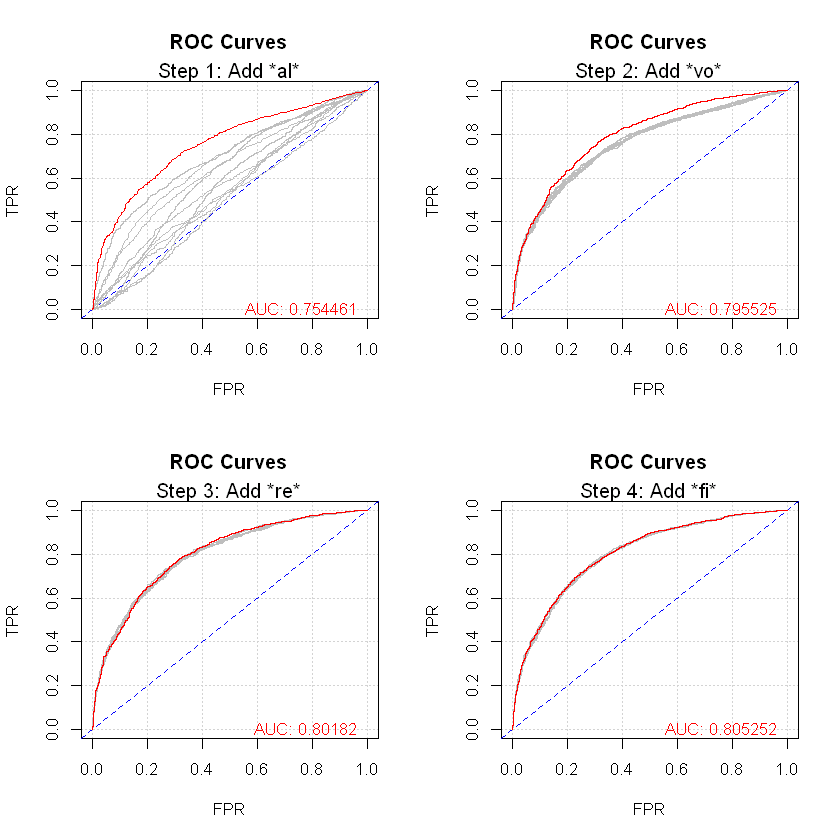

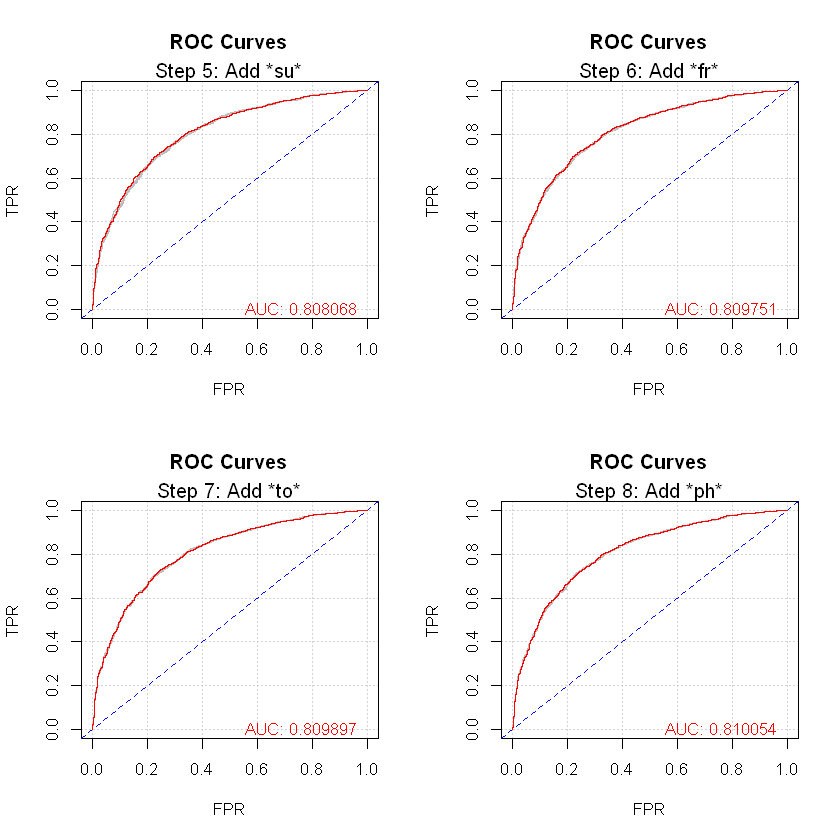

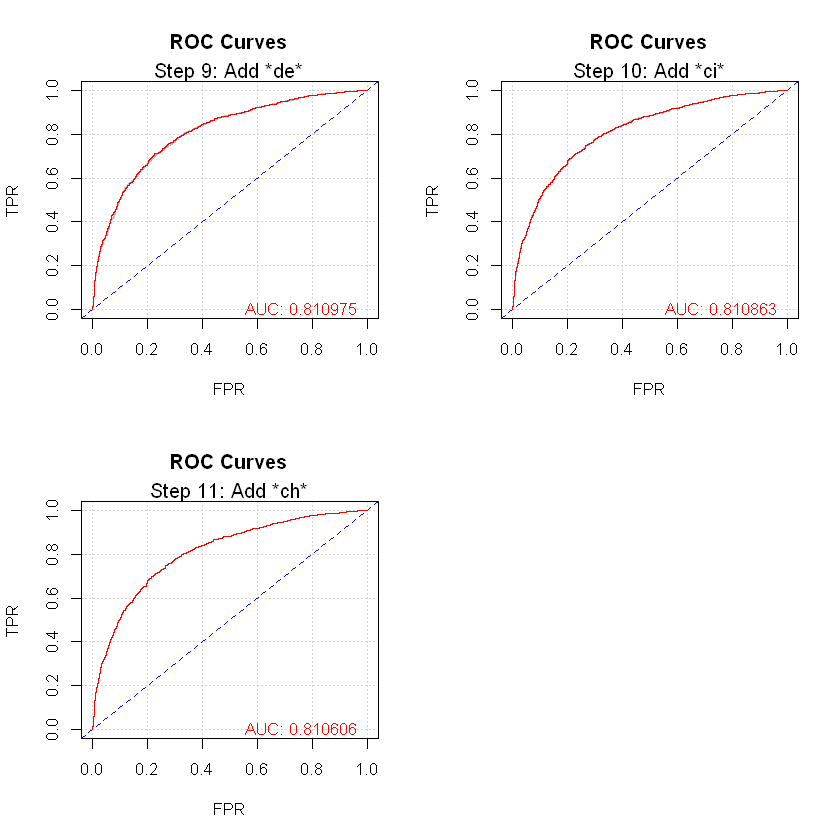

In [11]:
# Define a two-column (with equally-sized rows) plotting area.
par(mfrow = c(2, 2))

# Perform stepwise selection by cross-validated AUC,
# for a logistic regression model, for the data *d*.
st <- step_xv(d)

In [12]:
# Return the results of stepwise selection.
st

,Step,Var,AUC,SE
1,1,al,0.754460690824327,0.00857372937846022
2,2,vo,0.795524558626163,0.00805564612229573
3,3,re,0.80181951144518,0.00798859400081263
4,4,fi,0.805252442150838,0.00789712471948007
5,5,su,0.808067511810827,0.00782127353974585
6,6,fr,0.809750736488704,0.00778937940378813
7,7,to,0.809896579950056,0.00778716388377009
8,8,ph,0.810053642139204,0.0077938153241844
9,9,de,0.810975239852245,0.00776713919796375
10,10,ci,0.810863052574282,0.00776850119219252


In [13]:
# Return the model (step) with the highest AUC value.
st[st$AUC == max(st$AUC), ]

,Step,Var,AUC,SE
9,9,de,0.810975239852245,0.00776713919796375


In [14]:
# Return the models (steps) within one standard error of the AUC value,
# of the model with the the highest AUC value.
st[st$AUC >= max(st$AUC) - st$SE[st$AUC == max(st$AUC)], ]

,Step,Var,AUC,SE
4,4,fi,0.805252442150838,0.00789712471948007
5,5,su,0.808067511810827,0.00782127353974585
6,6,fr,0.809750736488704,0.00778937940378813
7,7,to,0.809896579950056,0.00778716388377009
8,8,ph,0.810053642139204,0.0077938153241844
9,9,de,0.810975239852245,0.00776713919796375
10,10,ci,0.810863052574282,0.00776850119219252
11,11,ch,0.810605852851842,0.00777120447031768


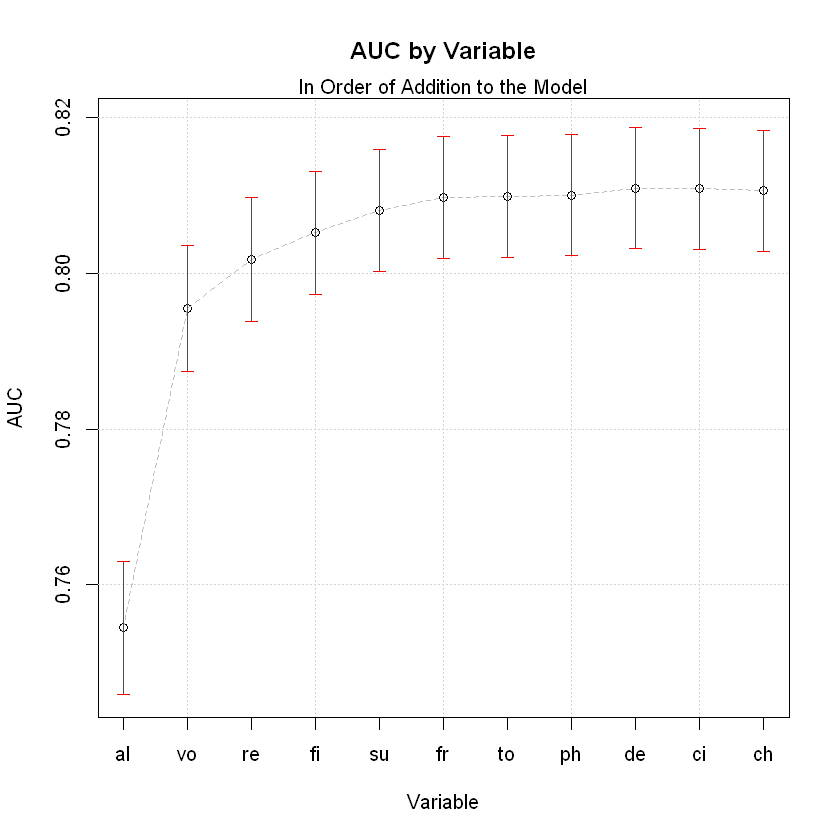

In [15]:
# Calculate the minimum and maximum y (AUC) values.
min_y <- min(st$AUC) - max(st$SE)
max_y <- max(st$AUC) + max(st$SE)

# Plot the AUC values for each step.
plot(st$AUC, xlab = "Variable", ylab = "AUC", main = "AUC by Variable",
     xaxt = "n", ylim = c(min_y, max_y))
grid()
mtext("In Order of Addition to the Model")
axis(1, at = 1:11, labels = st$Var)
lines(st$AUC, col = "grey", lty = 2)

# Show bars (modified arrows) for the AUC standard error for each step.
# Source: <stackoverflow.com/questions/13032777/scatter-plot-with-error-bars>.
arrows(st$Step, st$AUC - st$SE, st$Step, st$AUC + st$SE, code = 3, angle = 90,
       length = 0.05, col = "red")

## C.4 — Fit the Stepwise Model

Fit a logistic regression model, using the whole training set, using the variables identified by forward stepwise selection by cross-validated AUC (that is, in other words, the single best model as identified by stepwise selection), in particular:
* *alcohol* (*al*);
* *volatile acidity* (*vo*);
* *residual sugar* (*re*); and
* *fixed acidity* (*fi*).

In [16]:
# Define the vector of predictors for the stepwise model.
x_st <- st$Var[1:4]

# Define the formula for the stepwise model.
f_st <- paste("qu", paste(x_st, collapse = " + "), sep = " ~ ")

# Fit the stepwise model using the whole training set.
m_st <- glm(f_st, d, family = binomial)

## C.5 — Interpretation of the Stepwise Model

Relevant statistics for the stepwise model are shown below.  The stepwise model is statistically significant: the proportion of deviance explained by the model (being the difference between the null deviance and the residual deviance) corresponds to a *p* value of effectively zero.  There is a statistically-significant relationship between at least one of the predictors and the response pursuant to the model (see IDRE (2); R Documentation: anova.glm).

All four of the predictors are statistically significant: for each of the four predictors, the relatively low magnitude of the standard error relative to the relatively large magnitude of the coefficient corresonds to a large *z* statistic (and an equivalently low *p* value, i.e., the probability of observing a coefficient of the given magnitude were the null hypothesis true).  In other words, for each of the four predictors, the null hypothesis (that the "true" coefficient for the predictor is zero) is rejected (see James et al, 2015, p 134).  Further, the relatively higher *z* statistic and relatively lower *p* values (and relatively larger decrease in deviance) for *alcohol* (*al*) and *volatile acidity* (*vo*), relative to *residual sugar* (*re*) and *fixed acidity* (*fi*), is consistent with the relative increase in AUC for each of these varaibles in the stepwise selection procedure.

The coefficients represent the change in the log odds of the response for a one-unit change in the predictors, such that exponentiating the coefficients gives the change in the odds of the response for a one-unit change in the predictors (see IDRE (1); IDRE (2); see also James et al, 2015, pp 132-137).  In particular, for the stepwise model, the odds of a classification of "good" are:
* increased by a factor of approximately 3 ($e^{1.0887}$) for a one-unit increase in *alcohol* (*al*);
* decreased by a factor of approximately 1,000 ($e^{-6.9741}$) for a one-unit increase in *volatile acidity* (*vo*) (but note the small magnitude and limited range of values of *volatile acidity* (*vo*));
* increased by approximately 6% ($e^{0.0625}$) for a one-unit increase in *residual sugar* (*re*); and
* decreased by approximately 20% ($e^{-0.2460}$) for a one-unit increase in *fixed acidity* (*fi*).

In each case, these changes have to be interpreted in the context of the range and magnitude of the values for the relevant predictor.

Additionally, the ANOVA table for the model shows that the "order" of the predictors (as determined by forward stepwise selection) corresponds to the "order" of the predictors in terms of reduction in deviance.  In other words, successive predictors account for (exponentially) decreasing reduction in deviance.  This can be compared to the result of conventional forward stepwise selection (using the whole training set) by, for example, BIC, which produces a six-predictor model with the same first four predictors in the same order.

In [17]:
# Return the *p* value for the model.
1 - pchisq(m_st$null.deviance - m_st$deviance, m_st$df.null - m_st$df.residual)

[1] 0

In [18]:
# Return the summary statistics for the model.
summary(m_st)


Call:
glm(formula = f_st, family = binomial, data = d)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.1762  -0.8953   0.4309   0.7935   2.3890  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -7.325750   0.615586 -11.900  < 2e-16 ***
al           1.088730   0.049285  22.091  < 2e-16 ***
vo          -6.974085   0.477879 -14.594  < 2e-16 ***
re           0.062544   0.009288   6.734 1.65e-11 ***
fi          -0.246003   0.049640  -4.956 7.20e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 4194.0  on 3282  degrees of freedom
Residual deviance: 3267.6  on 3278  degrees of freedom
AIC: 3277.6

Number of Fisher Scoring iterations: 5


In [19]:
# Return the ANOVA table for the model.
format(round(anova(m_st, test = "Chisq"), digits = 4), 4)

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,3282,4193.984,NA
al,1,631.5361,3281,3562.447,0
vo,1,226.3404,3280,3336.107,0
re,1,43.5915,3279,3292.515,0
fi,1,24.8840,3278,3267.631,0


In [20]:
# Return the coefficients and exponentiated coefficients for the model.
co_step <- round(summary(m_st)$coefficients[ , 1][-1], 4)
co_step
round(exp(co_step), 6)

al      vo      re      fi 
 1.0887 -6.9741  0.0625 -0.2460

al       vo       re       fi 
2.970410 0.000936 1.064494 0.781922

In [21]:
# Define a minimal logistic regression model (intercept only).
m_min <- glm(qu ~ 1, d, family = binomial)

# Define a maximal logistic regression model (all predictors).
f_max <- formula(glm(qu ~ ., d, family = binomial))

# Perform forward stepwise variable selection by BIC.
m_st_BIC <- step(m_min, scope = f_max, direction = "forward", k = log(nrow(d)),
                 trace = 0)

# Return the ANOVA table for the model.
format(round(anova(m_st_BIC, test = "Chisq"), 4), 4)

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,3282,4193.984,NA
al,1,631.5361,3281,3562.447,0.000
vo,1,226.3404,3280,3336.107,0.000
re,1,43.5915,3279,3292.515,0.000
fi,1,24.8840,3278,3267.631,0.000
su,1,18.7294,3277,3248.902,0.000
fr,1,10.7705,3276,3238.132,0.001


## C.6 — Performance of the Stepwise Model

Apply the stepwise model to the test set.  A confusion matrix and ROC curve for the predicitons of the stepwise model in relation to the test set are shown below.

For the stepwise model, in relation to the test set:
* predictive accuracy is approximately 0.7 (equivalently, prediction error is approximately 0.3); and
* AUC is approximately 0.75, and the ROC curve is relatively "smooth" and deviates meaningfully from the diagonal, both indicating meaningful predictive performance.

More specifically:
* sensitivity (a.k.a. recall, true-positive rate), being the proportion of positive values (i.e. "good") in the test set correctly identified by the model, is approximately 0.85; and
* specificity (a.k.a. true-negative rate), being the proportion of negative values (i.e. "bad") in the test set correctly identified by the model, is approximately 0.43 (less than 50%).

(See James et al, 2015, pp 145-149; Fawcett, 2005, pp 862).

In [22]:
# Apply the stepwise model to the test set.
p_st <- predict(m_st, d_test, "response")

In [23]:
# Return the confusion matrix for the predictions of the stepwise model.
mat <- table(ifelse(p_st > 0.5, "good", "bad"), d_test$qu)
mat <- data.frame(mat)
colnames(mat) <- c("Pred", "True", "Count")
rownames(mat) <- c("TN", "FP", "FN", "TP")
mat["Proportion"] <- round(mat["Count"] / sum(mat["Count"]), 2)
mat

,Pred,True,Count,Proportion
TN,bad,bad,104,0.15
FP,good,bad,139,0.21
FN,bad,good,64,0.09
TP,good,good,371,0.55


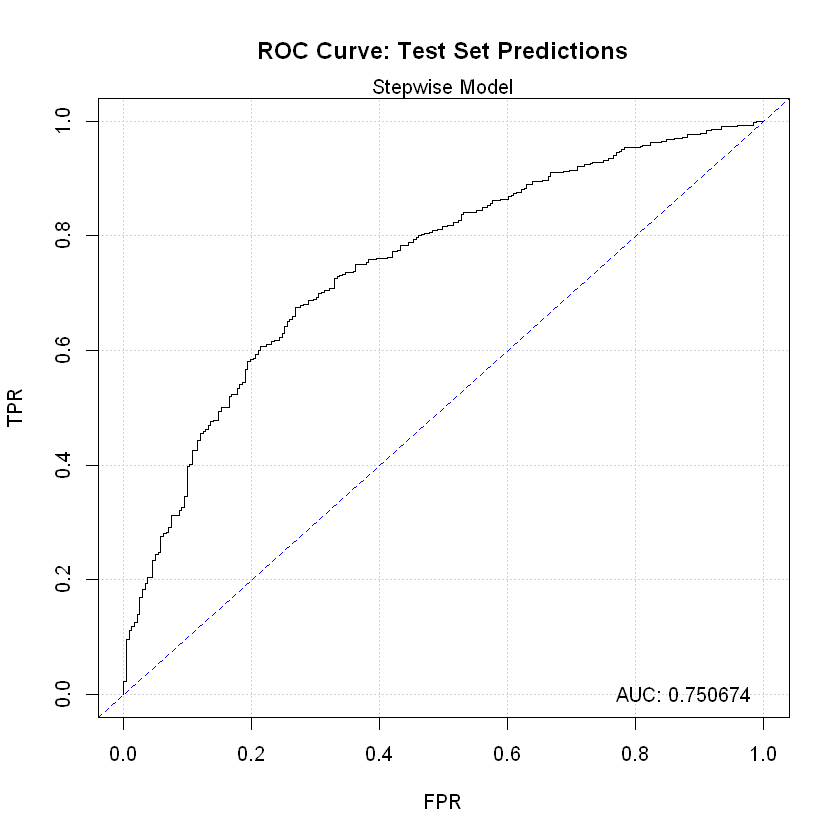

In [24]:
# The ROC curve for the predictions of the four-variable model,
# in relation to the test set.
r_st <- roc(as.vector(d_test$qu), p_st)

# Plot the ROC curve for the model in relation to the test set.
plot.new()
plot.window(xlim = c(1, 0), ylim = c(0, 1))
grid()
box()
abline(1, -1, col = "blue", lty = 2)
l <- seq(0,1,0.2)
axis(1, at = rev(l), labels = format(l, 2))
axis(2)
title(main = "ROC Curve: Test Set Predictions", xlab = "FPR", ylab = "TPR")
lines(r_st, lwd = 1)
text(0, 0, paste("AUC: ", round(pROC::auc(r_st), 6), sep = ""), pos = 2)
mtext("Stepwise Model")

---

# D — $L_2$ and $L_1$ Regularisation

## D.1 — Load Package *glmnet*

Load the package *glmnet*, which provides for:
* $L_2$ and $L_1$ regularisation; and
* the optimisation of the tuning parameter $\lambda$ by cross-validation.

In [25]:
# Load the package *glmnet*.
library(glmnet)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-5


Attaching package: 'glmnet'

The following object is masked from 'package:pROC':

    auc



## D.2 — Define Model Matrices and $\lambda$ Grid

Define:
* model matrices for the training and test sets (for use with the `glmnet`, `cv.glmnet`, and `predict` functions of the package *glmnet*); and
* a "grid" of values for the tuning parameter $\lambda$ (to be optimised by cross-validation, separately for each of the $L_2$ and $L_1$ shrinkage penalties).

In [26]:
# Define a model matrix for the training set (remove the intercept: redundant).
x_tr <- model.matrix(qu ~ ., d)[ , -1]

# Define a model matrix for the test set (remove the intercept: redundant).
x_te <- model.matrix(qu ~ ., d_test)[ , -1]

In [27]:
# Define a "grid" of lambda values, being 10^*s*,
# where *s* is a sequence of *n* values from *a* to *b*.
a <- -5
b <-  5
n <- 100
s <- seq(a, b, (b - a) / n)
g <- 10^s

## D.3 — $L_2$ Regularisation (Ridge Penalty)

### D.3.1 — Optimise $\lambda$ for the $L_2$ Shrinkage Penalty by Cross-Validation

Find the value of the tuning parameter $\lambda$ (between $10^{-5}$ and $10^{5}$) for the $L_2$ shrinkage penalty which optimises (maximises) average AUC, by cross-validation.

Plots for average AUC (cross-validated) and coefficient magnitude (not cross-validated) by $\lambda$ value are shown below.  It is evident that average AUC is more or less unchanged for low values of $\lambda$.  The $L_2$ penalty does not reduce the coefficients for any of the predictors to zero, meaning that the model is still functional even for relatively high values of $\lambda$ (average AUC does not drop below approximately 0.75, even for relatively high values of $\lambda$).  The value of $\lambda$ which maximises average AUC is effectively zero (that is, no penalty).  Following the so-called one-standard-error rule, the optimal value of $\lambda$, being the largest value of $\lambda$ corresponding to an average AUC within one standard error of the maximum average AUC, is approximately 0.1259.

In [28]:
# Set the random seed.
set.seed(1)

# Cross-validate lambda for the L2 shrinkage penalty,
# for a logistic regression model, for the training set,
# optimising (maximising) the average AUC value.
m_L2_xv <- cv.glmnet(x_tr, d$qu, alpha = 0, lambda = g, family = "binomial",
                     type.measure = "auc")

# Define the largest lambda value corresponding to an average AUC value,
# within 1 standard error of the maximum average AUC value.
lambda_L2 <- m_L2_xv$lambda.1se

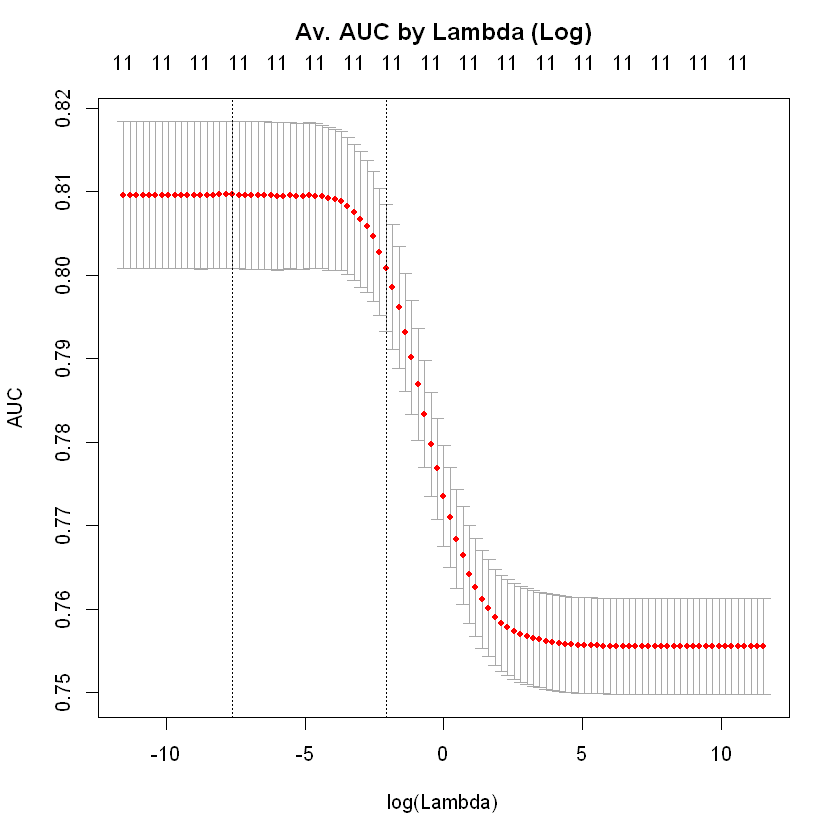

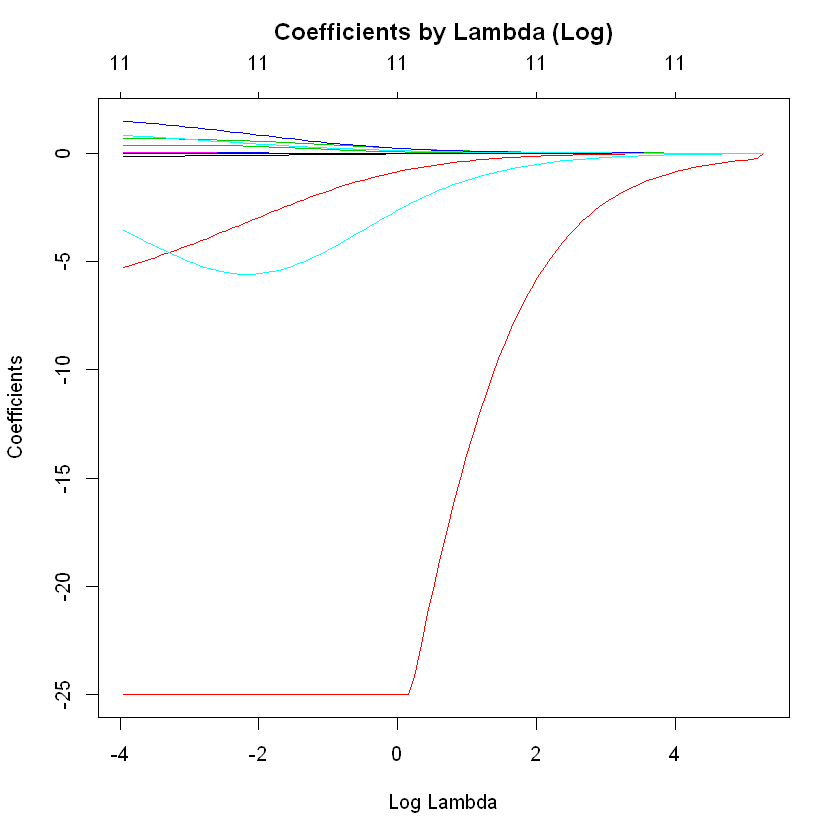

In [29]:
# Plot cross-validated average AUC value by lambda value (log).
plot(m_L2_xv)
title(bquote(atop(bold("Av. AUC by Lambda (Log)")), ""))

# Plot coefficient magnitude by lambda value (log).
m_temp_L2 <- glmnet(x_tr, d$qu, alpha = 0, family = "binomial", lower = -25)
plot(m_temp_L2, xvar = "lambda")
title(bquote(atop(bold("Coefficients by Lambda (Log)"), "")))

In [30]:
# Return the lambda value corresponding to the maximum average AUC value.
round(m_L2_xv$lambda.min, 6)

# Return the largest lambda value corresponding to an average AUC value,
# within 1 standard error of the maximum average AUC value.
round(m_L2_xv$lambda.1se, 6)

[1] 0.000501

[1] 0.125893

In [31]:
# Return the coefficients for:
#   - the lambda value for the maximum AUC
#   - the within-1-SE lambda value
co_L2_xv <- cbind(coef(m_L2_xv, "lambda.min")[ , 1],
                  coef(m_L2_xv, "lambda.1se")[ , 1])[-1, ]
co_L2_xv <- co_L2_xv[order(abs(co_L2_xv[ , 1]), decreasing = TRUE), ]
colnames(co_L2_xv) <- c("Max. AUC", "1-SE")
round(co_L2_xv, 4)

,Max. AUC,1-SE
de,-148.0327,-67.4367
vo,-6.4043,-3.0537
su,1.9349,0.9039
ph,1.1263,0.5949
al,0.9112,0.4066
ch,-0.6587,-5.3794
ci,0.3541,0.3442
re,0.1129,0.0208
fi,-0.0801,-0.0845
fr,0.0111,0.0060


### D.3.2 — Fit the $L_2$ Model

Fit a logistic regression model using the $L_2$ shrinkage penalty, with the optimised value for the tuning parameter $\lambda$, using the whole training set.

In [32]:
# Fit a logistic regression model using the L2 shrinkage penalty,
# with the optimised lambda value, using the whole training set.
m_L2 <- glmnet(x_tr, d$qu, alpha = 0, lambda = lambda_L2, family = "binomial")

### D.3.3 — Interpretation of the $L_2$ Model

The $L_2$ model is statistically significant (there is a statistically-significant relationship between at least one of the predictors and the response, pursuant to the model).  The proportion of deviance explained by the model (being the difference between the null deviance and the residual deviance) corresponds to a *p* value of effectively zero (see IDRE (2); R Documentation: anova.glm).

The $L_2$ penalty does not reduce the coefficients for any of the predictors to zero.  The coefficients represent the change in the log odds of the response for a one-unit change in the predictors, such that exponentiating the coefficients gives the change in the odds of the response for a one-unit change in the predictors (see IDRE (1); IDRE (2); see also James et al, 2015, pp 132-137).  In particular, for the $L_2$ model, the odds of a classification of "good" are:
* decreased, in essence, to zero ($e^{-67}$) for a one-unit increase in *density* (*de*) (but note the limited range of values for *de*);
* decreased by a factor of approximately 200 ($e^{-5.375}$) for a one-unit increase in *chlorides* (*ch*) (but note the limited range of values for *chlorides* (*ch*));
* decreased by a factor of approximately 20 ($e^{-3.0536}$) for a one-unit increase in *volatile acidity* (*vo*);
* increased by a factor of approximately 2.5 ($e^{0.904}$) for a one-unit increase in *sulphates* (*su*);
* increased by a factor of approximately 1.8 ($e^{0.5951}$) for a one-unit increase in *ph* (*ph*);
* increased by a factor of approximately 1.5 ($e^{0.4067}$) for a one-unit increase in *alcohol* (*al*);
* increased by a factor of approximately 1.4 ($e^{0.3447}$) for a one-unit increase in *citric acid* (*ci*);
* decreased by approximately 10% ($e^{-0.0845}$) for a one-unit increase in *fixed acidity* (*fi*);
* increased by approximately 2% ($e^{0.0208}$) for a one-unit increase in *residual sugar* (*re*);
* increased by approximately 1% ($e^{0.006}$) for a one-unit increase in *free sulfur dioxide* (*fr*); and
* decreased by less than 1% ($e^{-0.0023}$) for a one-unit increase in *total sulfur dioxide* (*to*).

In each case, these changes have to be interpreted in the context of the range and magnitude of the values for the relevant predictor.

In [33]:
# Return the *p* value for the model.
1 - pchisq(m_L2$dev.ratio * m_L2$nulldev, m_L2$df)

[1] 0

In [34]:
# Return the coefficients for the L2 model,
# in decreasing order of magnitude.
co_L2 <- coef(m_L2)[-1, 1]
co_L2 <- co_L2[order(abs(co_L2), decreasing = TRUE)]
round(co_L2, 4)

de       ch       vo       su       ph       al       ci       fi 
-67.4495  -5.3750  -3.0536   0.9040   0.5951   0.4067   0.3447  -0.0845 
      re       fr       to 
  0.0208   0.0060  -0.0023

In [35]:
# Return the exponentiated coefficients for the L2 model.
round(exp(co_L2), 6)

de       ch       vo       su       ph       al       ci       fi 
0.000000 0.004631 0.047187 2.469439 1.813154 1.501881 1.411503 0.919016 
      re       fr       to 
1.021039 1.006001 0.997721

### D.3.4 — Performance of the $L_2$ Model

Apply the $L_2$ model to the test set.  A confusion matrix and ROC curve for the predicitons of the $L_2$ model in relation to the test set are shown below.

For the $L_2$ model, in relation to the test set:
* predictive accuracy is approximately 0.71 (equivalently, prediction error is approximately 0.29); and
* AUC is approximately 0.76, and the ROC curve is relatively "smooth" and deviates meaningfully from the diagonal, both indicating meaningful predictive performance.

More specifically:
* the sensitivity (a.k.a. recall, true-positive rate), being the proportion of positive values (i.e. "good") in the test set correctly identified by the model, is approximately 0.93; and
* the specificity (a.k.a. true-negative rate), being the proportion of negative values (i.e. "bad") in the test set correctly identified by the model, is approximately 0.30 (less than 50%).

(See James et al, 2015, pp 145-149; Fawcett, 2005, pp 862).

In [36]:
# Apply the L2 model to the test set.
p_L2 <- predict(m_L2, newx = x_te, type = "response")

# Compute the ROC curve for the L2 model in relation to the test set.
r_L2 <- roc(as.vector(d_test$qu), as.vector(p_L2))

In [37]:
# Return the confusion matrix for the predictions of the L2 model,
# in relation to the test set.
mat <- table(ifelse(p_L2 > 0.5, "good", "bad"), d_test$qu)
mat <- data.frame(mat)
colnames(mat) <- c("Pred", "True", "Count")
rownames(mat) <- c("TN", "FP", "FN", "TP")
# mat <- mat[c("TP", "FP", "TN", "FN"), ]
mat["Proportion"] <- round(mat["Count"] / sum(mat["Count"]), 2)
mat

,Pred,True,Count,Proportion
TN,bad,bad,73,0.11
FP,good,bad,170,0.25
FN,bad,good,30,0.04
TP,good,good,405,0.6


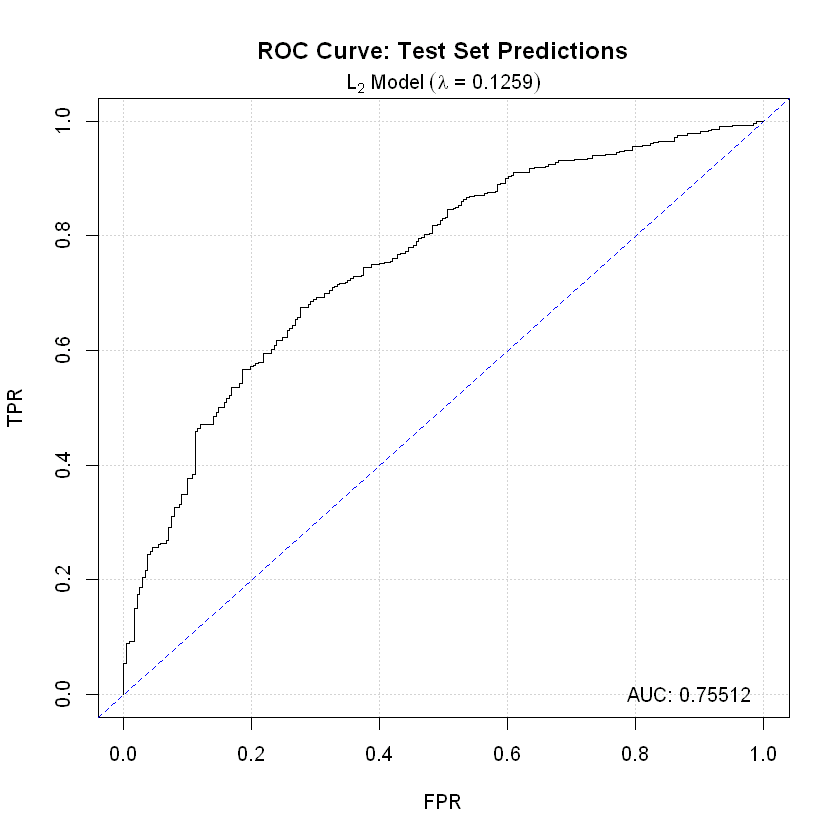

In [38]:
# Plot the ROC curve for the L2 model in relation to the test set.
plot.new()
plot.window(xlim = c(1, 0), ylim = c(0, 1))
grid()
box()
abline(1, -1, col = "blue", lty = 2)
l <- seq(0,1,0.2)
axis(1, at = rev(l), labels = format(l, 2))
axis(2)
title(main = "ROC Curve: Test Set Predictions", xlab = "FPR", ylab = "TPR")
# plot(r_L2, lwd = 1, add = TRUE)
lines(r_L2, lwd = 1)
text(0, 0, paste("AUC: ", round(pROC::auc(r_L2), 6), sep = ""), pos = 2)
mtext(expression(L[2] ~ "Model" ~ (lambda ~ "= 0.1259")))

## D.4 — $L_1$ Regularisation (Lasso Penalty)

### D.4.1 — Optimise $\lambda$ for the $L_1$ Shrinkage Penalty by Cross-Validation

Find the value of the tuning parameter $\lambda$ (between $10^{-5}$ and $10^5$) for the $L_1$ shrinkage penalty which optimises (maximises) average AUC, by cross-validation.

Plots for average AUC (cross-validated) and coefficient magnitude (not cross-validated) by $\lambda$ value are shown below.  As for the $L_2$ penalty, average AUC is more or less unchanged for low values of $\lambda$ for the $L_1$ penalty.  In contrast to the $L_2$ penalty, large values of $\lambda$ for the $L_1$ penalty reduce each of the coefficients to zero (producing, in effect, a null model), resulting in average AUC values close to 0.5 (representing random predictions).  The value of $\lambda$ which maximises average AUC is effectively zero (that is, no penalty).  Following the one-standard-error rule, the optimal value of $\lambda$, being the largest value of $\lambda$ corresponding to an average AUC within one standard error of the maximum average AUC, is 0.019953.  The optimal value of $\lambda$ reduces the coefficients for the predictors *citric acid* (*ci*), *chlorides* (*ch*), *total sulfur dioxide* (*to*), and *density* (*de*) to zero.  This is in contrast to the $L_2$ penalty, for which the predictors *ch* and *de* (effectively excluded from the model under the $L_1$ penalty) are the two predictors with the largest coefficients (-5.375 and -67.4495).

In [39]:
# Set the random seed.
set.seed(1)

# Cross-validate lambda for the L1 shrinkage penalty,
# for a logistic regression model, for the training set,
# optimising (maximising) the average AUC value.
m_L1_xv <- cv.glmnet(x_tr, d$qu, alpha = 1, lambda = g, family = "binomial",
                     type.measure = "auc")

# Define the largest lambda value corresponding to an average AUC value,
# within 1 standard error of the maximum average AUC value.
lambda_L1 <- m_L1_xv$lambda.1se

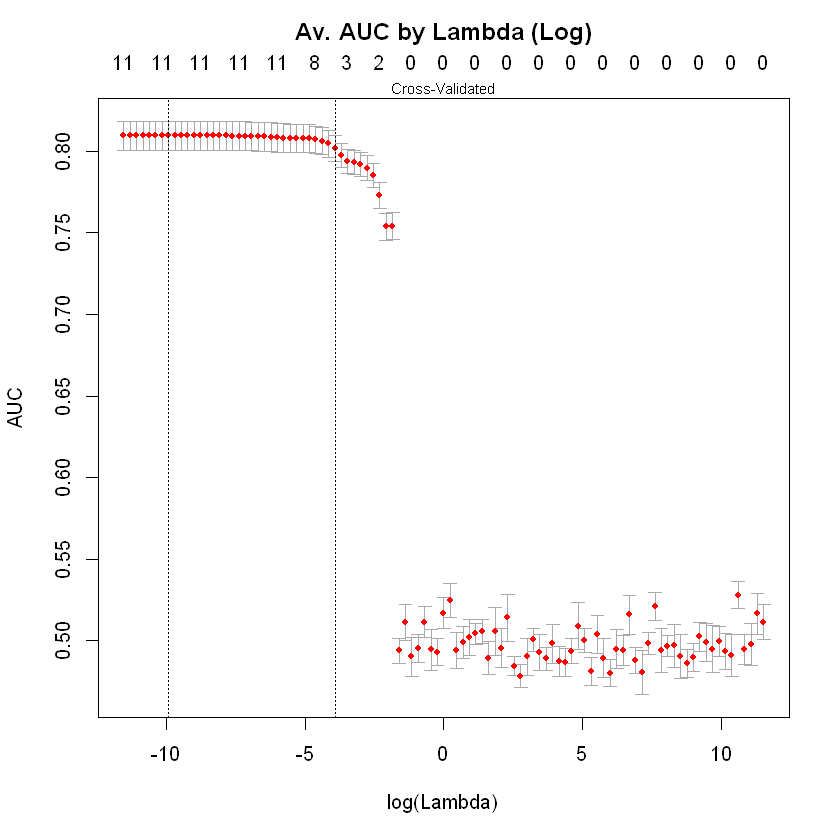

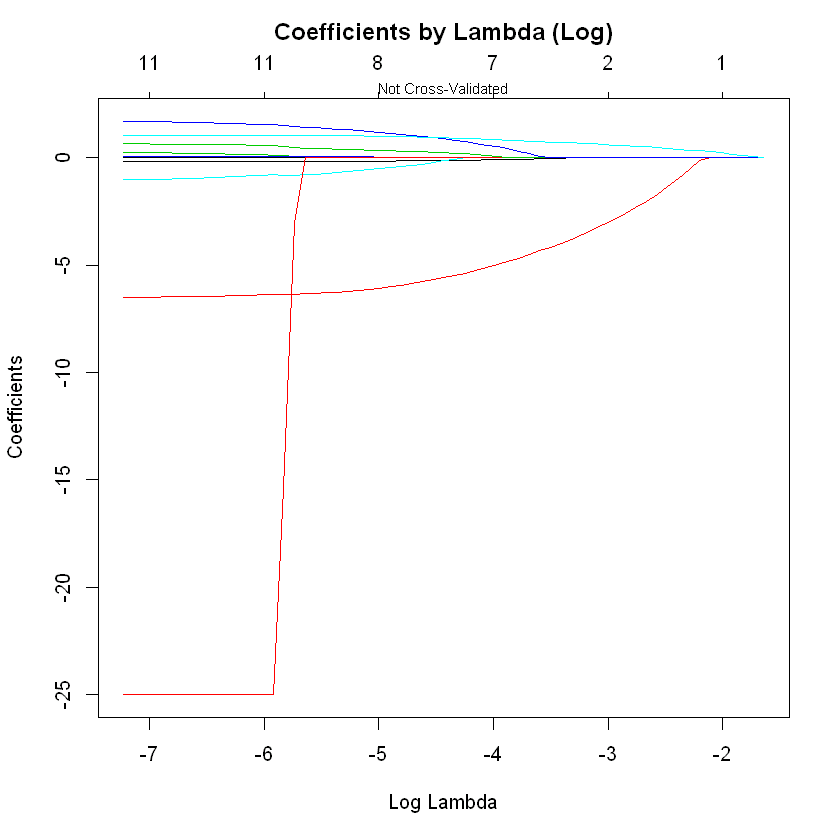

In [40]:
# Plot cross-validated average AUC value by lambda value (log).
plot(m_L1_xv)
title(bquote(atop(bold("Av. AUC by Lambda (Log)"), "")))
mtext("Cross-Validated", cex = 0.75)

# Plot coefficient magnitude by lambda value (log).
m_temp_L1 <- glmnet(x_tr, d$qu, alpha = 1, family = "binomial", lower = -25)
plot(m_temp_L1, xvar = "lambda")
title(bquote(atop(bold("Coefficients by Lambda (Log)"), "")))
mtext("Not Cross-Validated", cex = 0.75)

In [41]:
# Return the lambda value corresponding to the maximum average AUC value.
round(m_L1_xv$lambda.min, 6)

# Return the largest lambda value  corresponding to the largest average AUC value,
# within 1 standard error of the maximum average AUC value.
round(m_L1_xv$lambda.1se, 6)

[1] 5e-05

[1] 0.019953

In [42]:
# Return the coefficients for:
#   - the lambda value for the maximum AUC
#   - the within-1-SE lambda value
co_L1_xv <- cbind(coef(m_L1_xv, "lambda.min")[ , 1],
                  coef(m_L1_xv, "lambda.1se")[ , 1])[-1, ]
co_L1_xv <- co_L1_xv[order(abs(co_L1_xv[ , 1]), decreasing = TRUE), ]
colnames(co_L1_xv) <- c("Max. AUC", "1-SE")
round(co_L1_xv, 4)

,Max. AUC,1-SE
de,-151.5906,0.0000
vo,-6.4459,-4.8959
su,1.9460,0.4577
ph,1.1398,0.0589
al,0.9150,0.8397
ch,-0.5384,0.0000
ci,0.3485,0.0000
re,0.1151,0.0144
fi,-0.0775,-0.0819
fr,0.0110,0.0032


### D.4.2 — Fit the $L_1$ Model

Fit a logistic regression model using the $L_1$ shrinkage penalty, with the optimised value for the tuning parameter $\lambda$, using the whole training set.

In [43]:
# Fit a logistic regression model using the L1 shrinkage penalty,
# with the optimised lambda value, using the whole training set.
m_L1 <- glmnet(x_tr, d$qu, lambda = lambda_L1, alpha = 1, family = "binomial")

### D.4.3 — Interpretation of the $L_1$ Model

The $L_1$ model is statistically significant (there is a statistically-significant relationship between at least one of the predictors and the response, pursuant to the model).  The proportion of deviance explained by the model (being the difference between the null deviance and the residual deviance) corresponds to a *p* value of effectively zero (see IDRE (2); R Documentation: anova.glm).

The $L_1$ penalty reduces the coefficients for the predictors *chlorides* (*ch*), *citric acid* (*ci*), *density* (*de*), and *total sulfur dioxide* (*to*) to zero (effectively excluding these predictors from the model).  The coefficients for the "remaining" predictors represent the change in the log odds of the response for a one-unit change in the predictors, such that exponentiating the coefficients gives the change in the odds of the response for a one-unit change in the predictors (see IDRE (1); IDRE (2); see also James et al, 2015, pp 132-137).  In particular, for the $L_1$ model, the odds of a classification of "good" are:
* decreased by a factor of approximately 133 ($e^{-4.896}$) for a one-unit increase in *volatile acidity* (*vo*) (but note the range and magnitude of values for *volatile acidity* (*vo*));
* increased by a factor of approximately 2.3 ($e^{0.8397}$) for a one-unit increase in *alcohol* (*al*);
* increased by a factor of approximately 1.6 ($e^{0.4577}$) for a one-unit increase in *sulphates* (*su*);
* decreased by approximately 8% ($e^{-0.0819}$) for a one-unit increase in *fixed acidity* (*fi*);
* increased by approximately 6% ($e^{0.0589}$) for a one-unit increase in *ph* (*ph*);
* increased by approximately 1% ($e^{0.0144}$) for a one-unit increase in *residual sugar* (*re*); and
* increased by less than 1% ($e^{0.0032}$) for a one-unit increase in *free sulfur dioxide* (*fr*).

In each case, these changes have to be interpreted in the context of the range and magnitude of the values for the relevant predictor.

In [44]:
# Return the *p* value for the model.
1 - pchisq(m_L1$dev.ratio * m_L1$nulldev, m_L1$df)

[1] 0

In [45]:
# Return the coefficients for the L1 model,
# in decreasing order of magnitude.
co_L1 <- coef(m_L1)[-1, 1]
co_L1 <- co_L1[order(abs(co_L1), decreasing = TRUE)]
round(co_L1, 4)

vo      al      su      fi      ph      re      fr      ci      ch      to 
-4.8960  0.8397  0.4577 -0.0819  0.0589  0.0144  0.0032  0.0000  0.0000  0.0000 
     de 
 0.0000

In [46]:
# Return the exponentiated coefficients for the L1 model.
round(exp(co_L1), 6)[1:7]

vo       al       su       fi       ph       re       fr 
0.007476 2.315772 1.580462 0.921401 1.060624 1.014482 1.003162

### D.4.4 — Performance of the $L_1$ Model

Apply the $L_1$ model to the test set.  A confusion matrix and ROC curve for the predicitons of the $L_1$ model in relation to the test set are shown below.

For the $L_1$ model, in relation to the test set:
* predictive accuracy is approximately 0.71 (equivalently, prediction error is approximately 0.29); and
* AUC is approximately 0.75, and the ROC curve is relatively "smooth" and deviates meaningfully from the diagonal, both indicating meaningful predictive performance.

More specifically:
* sensitivity (a.k.a. recall, true-positive rate), being the proportion of positive values (i.e. "good") in the test set correctly identified by the model, is approximately 0.88; and
* specificity (a.k.a. true-negative rate), being the proportion of negative values (i.e. "bad") in the test set correctly identified by the model, is approximately 0.39 (less than 50%).

(See James et al, 2015, pp 145-149; Fawcett, 2005, pp 862).

In [47]:
# Apply the L_1 model to the test set.
p_L1 <- predict(m_L1, newx = x_te, type = "response")

# Compute the ROC curve for the L_1 model in relation to the test set.
r_L1 <- roc(as.vector(d_test$qu), as.vector(p_L1))

In [48]:
# Return the confusion matrix for the predictions of the L_1 model,
# in relation to the test set.
mat <- table(ifelse(p_L1 > 0.5, "good", "bad"), d_test$qu)
mat <- data.frame(mat)
colnames(mat) <- c("Pred", "True", "Count")
rownames(mat) <- c("TN", "FP", "FN", "TP")
# mat <- mat[c("TP", "FP", "TN", "FN"), ]
mat["Proportion"] <- round(mat["Count"] / sum(mat["Count"]), 2)
mat

,Pred,True,Count,Proportion
TN,bad,bad,95,0.14
FP,good,bad,148,0.22
FN,bad,good,52,0.08
TP,good,good,383,0.56


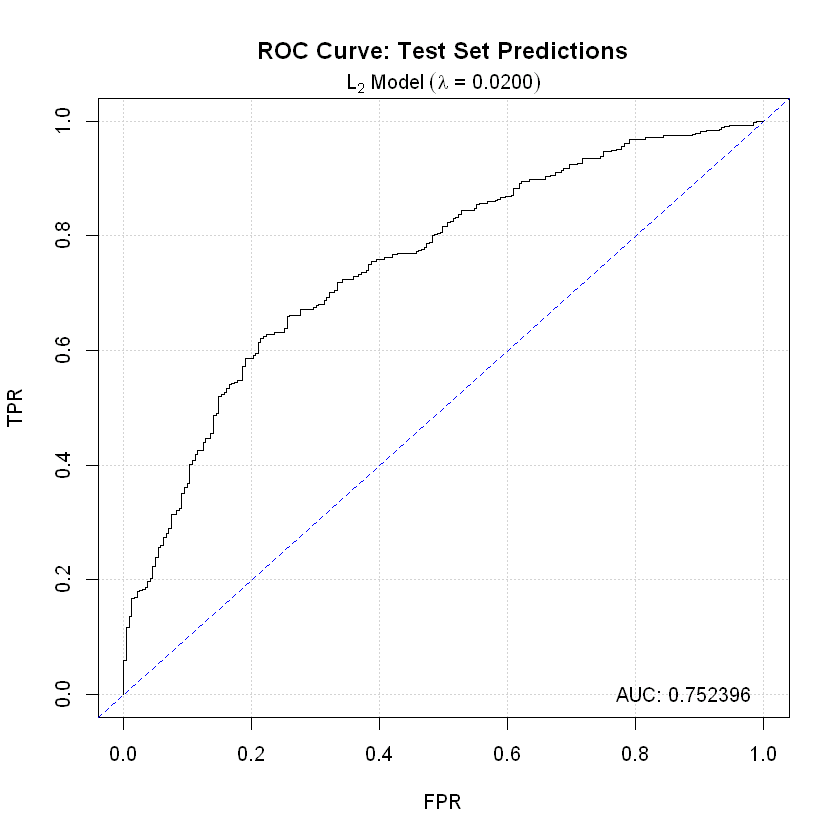

In [49]:
# Plot the ROC curve for the L_1 model in relation to the test set.
plot.new()
plot.window(xlim = c(1, 0), ylim = c(0, 1))
grid()
box()
abline(1, -1, col = "blue", lty = 2)
l <- seq(0,1,0.2)
axis(1, at = rev(l), labels = format(l, 2))
axis(2)
title(main = "ROC Curve: Test Set Predictions", xlab = "FPR", ylab = "TPR")
# plot(r_L2, lwd = 1, add = TRUE)
lines(r_L1, lwd = 1)
text(0, 0, paste("AUC: ", round(pROC::auc(r_L1), 6), sep = ""), pos = 2)
mtext(expression(L[2] ~ "Model" ~ (lambda ~ "= 0.0200")))

---

# E — Discussion

## E.1 — Predictive Performance

The ROC curves for each of the models (in relation to the test set) are shown together below.  The predictive performance of each of the models (in relation to the test set) is very similar.  Each of the models achieves predictive accuracy of approximately 0.7 (or, equivalently, prediction error of approximately 0.3).  Likewise, each of the models achieves AUC of approximately 0.75.  Further, the "shape" of the ROC curve for each of the models is almost the same (in each case, evidently deviating from the diagonal, corresponding to AUC values greater than 0.5, and indicating meaningful predictive performance).

The predictive performance of the models can be distinguished (to some extent) in terms of sensitivity (true-positive rate) and specificity (true-negative rate).  For the stepwise model, sensitivity is approximately 0.85 and specificity is approximately 0.43.  For the $L_1$ model, sensitivity is approximately 0.88 and specificity is approximately 0.39 (that is, relative to the stepwise model, sensitivity is higher and specificity is lower).  For the $L_2$ model, sensitivity is approximately 0.93 and specificity is approximately 0.3 (that is, relative to the $L_1$ model, sensitivity is higher and specificity is lower).  (Presumably, the higher sensitivity of the $L_2$ model corresponds to the very slight "lift" in the ROC curve for false-positive-rate values between approximately 0.5 and 0.75, as compared to the ROC curves for the stepwise and $L_1$ models.)

In other words, broadly speaking, each of the models performs well in terms of correctly classifying "good" observations, and each of the models performs poorly in terms of correctly classifying "bad" observations (less than 50% of "bad" observations are correctly classified by each model).  The higher sensitivities of the $L_1$ and $L_2$ models compared to the stepwise model are balanced by lower specificities.  None of the models clearly outperforms the other models.  Empirically, however, in terms of "pure" predictive performance, as measured by AUC, the $L_2$ model is the best model (although the difference is very small).

## E.2 — Bias vs Variance (Overfitting)

Each of the model-selection methods (forward stepwise selection by cross-validation, $L_2$ regularisation, and $L_1$ regularisation), appears to have produced a broadly similar result in terms of constraining overfitting.  The stepwise and $L_1$ models, in terms of the number of predictors, the particular predictors, and the magnitude of the coefficients for the predictors, are reasonably similar.  The $L_2$ model is inherently different, in that all of the predictors are included in the model.  Additionally, the magnitude of the coefficients for the predictors are markedly different for the $L_2$ model as compared to either the stepwise or $L_1$ models.  Nevertheless, as detailed above, the predictive performance of the models (in relation to the test set) is very similar, and the standard error for the AUC for each of the models (shown with the ROC curves, below) is very similar.

It is interesting, however, that each of the model-selection methods significantly overestimated the "true" performance of the model.  That is, each of the methods produced a cross-validated AUC (or average AUC, in the case of $L_2$ and $L_1$ regularisation) of approximately 0.8, significantly above the "true" AUC of approximately 0.75 for each model.  Note, though, that the test-set AUC for each of the models is close to the cross-validated AUC (from the stepwise selection procedure) for a model including only *al*, which suggests that *al* is by far the most "meaningful" predictor (and, equivalently, that all or almost all of the other predictors induce as much noise as additional predictive performance).

## E.3 — Methodology and Interpretability

It is difficult to meaningfully distinguish the models in terms of predictive performance or the control of overfitting.  However, there are axiomatic differences between the methods used to produce the models.  In particular, forward stepwise selection and $L_1$ regularisation perform variable selection, whereas $L_2$ regularisation does not.  As a result, in this instance, the stepwise and $L_1$ models are, arguably, more easily interpreted (and more explanatory of the data and relationships between the response and the predictors), as they include fewer predictors.  Further, forward stepwise selection is iterative (involving the comparison of models with different subsets of predictors), whereas both $L_2$ and $L_1$ regularisation work on all of the predictors (James et al, 2015, pp 215, 218-219, 223).

The coefficients of the predictors for each of the models are shown together below.  As noted above, the changes to the odds (of a classification of "good") for a one-unit change for each of the predictors has to be interpreted in the context of the range and magnitude of the values for the relevant predictor.  In this way, the problem of interpretability for the $L_2$ model becomes clear.  That is, first, the interpretation of the model requires the interpretation of all of the predictors in the context of the range and magnitude of their values, which, as all of the predictors are included in the model, is a much more complex task for the $L_2$ model (versus the $L_1$ model, let alone versus the stepwise model).  Second, the meaning of the coefficients for the model, in practical terms, is obfuscated by large-magnitude coefficients for predictors which are of little interest (that is, for example, *density* (*de*) and *chlorides* (*ch*)): the same predictors are completely excluded from the other models (and the *prima facie* "significance" of the predictors in terms of the magnitude of their coefficients is negated by the small magnitude and range of values for the relevant predictors).  In this sense, the stepwise and $L_1$ models are greatly preferable.

In [50]:
# Return the coefficients for each of the stepwise, L1, and L2 models,
# in decreasing order of magnitude.
co_all <- merge(co_step, cbind(co_L1, co_L2), by = "row.names", all = TRUE)
rownames(co_all) <- co_all[ , 1]
co_all <- co_all[ , -1]
colnames(co_all) <- c("Step", "L1", "L2")
co_all <- co_all[order(abs(co_all["Step"]),
                       abs(co_all["L1"]),
                       abs(co_all["L2"]), decreasing = TRUE), ]
print(round(co_all, 4))

      Step      L1       L2
vo -6.9741 -4.8960 -67.4495
al  1.0887  0.8397  -5.3750
fi -0.2460 -0.0819   0.9040
re  0.0625  0.0144   0.4067
su      NA  0.4577  -3.0536
ph      NA  0.0589   0.5951
fr      NA  0.0032   0.3447
ci      NA  0.0000  -0.0845
ch      NA  0.0000   0.0208
to      NA  0.0000   0.0060
de      NA  0.0000  -0.0023


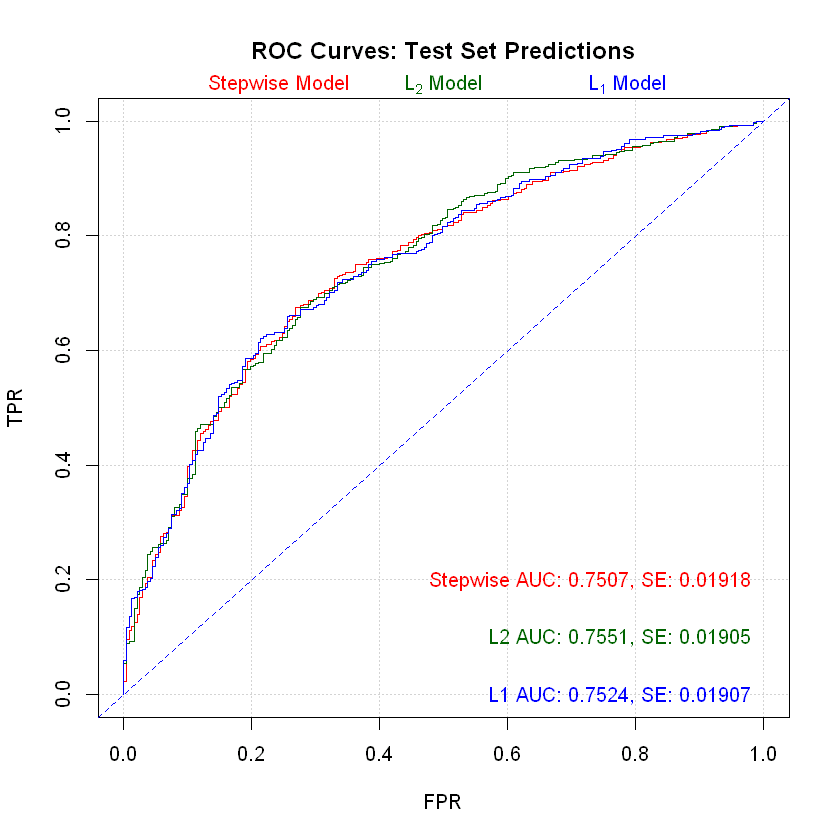

In [51]:
# Plot the ROC curves for each of the stepwise, L2, and L1 models,
# in relation to the test set.
plot.new()
plot.window(xlim = c(1, 0), ylim = c(0, 1))
grid()
box()
abline(1, -1, col = "blue", lty = 2)
l <- seq(0,1,0.2)
axis(1, at = rev(l), labels = format(l, 2))
axis(2)
title(main = "ROC Curves: Test Set Predictions", xlab = "FPR", ylab = "TPR")
lines(r_st, col = "red", lwd = 1)
lines(r_L2, col = "darkgreen", lwd = 1)
lines(r_L1, col = "blue", lwd = 1)
text(0, 0.2, paste("Stepwise AUC: ",
                   round(pROC::auc(r_st), 4),
                   ", SE: ",
                   round(sqrt(var(r_st)), 5),
                   sep = ""), pos = 2, col = "red")
text(0, 0.1, paste("L2 AUC: ",
                   round(pROC::auc(r_L2), 4),
                   ", SE: ",
                   round(sqrt(var(r_L2)), 5),
                   sep = ""), pos = 2, col = "darkgreen")
text(0, 0, paste("L1 AUC: ",
                 round(pROC::auc(r_L1), 4),
                 ", SE: ",
                 round(sqrt(var(r_L1)), 5),
                 sep = ""), pos = 2, col = "blue")
mtext(c("Stepwise Model",
        expression(L[2] ~ "Model"),
        expression(L[1] ~ "Model")), adj = c(0.20,0.50,0.80), col = c("red", "darkgreen", "blue"))

---

# Conclusion

For the given data, stepwise selection by cross-validated AUC, $L_2$ regularisation, and $L_1$ regularisation, produce models with very similar predictive performance (measured by AUC in relation to the test set).  Strictly speaking, the predictive performance of the $L_2$ model is highest, and in that sense it is the "best" model out of the three.  However, its higher sensitivity relative to the two other models is balanced by a lower specificity (which is true also of the $L_1$ model relative to the stepwise model) and, in any case, the difference in predictive performance is very slight.  Additionally, for practical purposes, the interpretability of the stepwise and $L_1$ models is significantly more straightforward.  In a sense, the $L_1$ model combines the advantages of the other models: the $L_1$ regularisation method performs variable selection, as for the stepwise model, increasing interpretability and, additionally, the $L_1$ regularisation method works on the full set of predictors, as for the $L_2$ regularisation method, rather than involving the iterative comparison of different subsets of potential predictors.  For these reasons, in practice, the $L_1$ model is preferrable, although solely in terms of predictive performance, the $L_2$ model is the "best" model.

---

# References

* Charpentier, A. (2015). Variable Selection Using Cross-Validation (and Other Techniques).<br>Retrieved from: http://freakonometrics.hypotheses.org/19925
* Fawcett, T. (2005). An Introduction to ROC Analysis. *Pattern Recognition Letters*, 27, 861-874.<br>Retrieved from: https://ccrma.stanford.edu/workshops/mir2009/references/ROCintro.pdf
* Friedman, J., Hastie, T., Simon, N., Tibshirani, R. (2016). R Package: glmnet.<br>Documentation: https://cran.r-project.org/web/packages/glmnet/glmnet.pdf
* Hastie, T., Tibshirani, R., Friedman, J. (2009). *The Elements of Statistical Learning: Data Mining, Inference, and Prediction*.<br>Retrieved from: http://statweb.stanford.edu/~tibs/ElemStatLearn/
* James, G., Witten, D., Hastie, T., Tibshirani, R. (2015). *An Introduction to Statistical Learning with Applications in R*.<br>Retrieved from: http://www-bcf.usc.edu/~gareth/ISL/
* Robin, X., Turck, N., Hainard, A., Tiberti, N., Lisacek, F., Sanchez, J., Müller, M. (2016). R Package: pROC.<br>Documentation: https://cran.r-project.org/web/packages/pROC/pROC.pdf
* UCLA Institute for Digital Research and Education. (n.d.). *FAQ: How Do I Interpret Odds Ratios in Logistic Regression?*<br>Retrieved from: http://www.ats.ucla.edu/stat/mult_pkg/faq/general/odds_ratio.htm
* UCLA Institute for Digital Research and Education. (n.d.). *R Data Analysis Examples: Logit Regression*.<br>Retrieved from: http://www.ats.ucla.edu/stat/r/dae/logit.htm